In [1]:
# korekta błędu w Keras po zmianie w bibliotece numpy
import numpy as np
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# wyłączenie ostrzeżeń
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Neuronowy transfer stylu

Kolejnym ważnym rozwiązaniem modyfikującym obrazy, opartym na technologii uczenia głębokiego, jest neuronowy transfer stylu opracowany latem 2015 r. przez zespół kierowany przez Leona Gatysego . Algorytm neuronowego transferu stylu od tego czasu był wielokrotnie usprawniany i modyfikowany. Zastosowano go w wielu aplikacjach pozwalających na edycję zdjęć przy użyciu smartfona. Dla uproszczenia skupimy się na oryginalnej wersji tego algorytmu.

Neuronowy transfer stylu polega na zastosowaniu stylu obrazu referencyjnego w celu przetworzenia innego obrazu z zachowaniem jego zawartości. Przykład tego procesu pokazano na rysunku 8.7.



![style transfer](img\8_3.png)


Pojęcie stylu odnosi się do tekstur, kolorów i sposobu przedstawiania rzeczy widocznych na obrazie. Treścią określamy wysokopoziomową makrostrukturę obrazu. Niebieskie i żółte linie narysowane pędzlem widoczne na rysunku (obraz Gwiaździsta noc namalowany przez Vincenta van Gogha) charakteryzują styl, a budynki widoczne na zdjęciu Tübingen są treścią.

Idea transferu stylu powiązana z generowaniem tekstur była znana w środowisku osób zajmujących się przetwarzaniem obrazu na długo przed pojawieniem się w 2015 r. neuronowego transferu stylu, ale transfer stylu oparty na technikach uczenia głębokiego okazał się dawać o wiele lepsze rezultaty od tych, które uzyskiwano z zastosowaniem klasycznych technik przetwarzania obrazu. Ta nowatorska technika zyskała wiele kreatywnych zastosowań.

Implementacja transferu stylu jest oparta na tych samych rozwiązaniach, co wszystkie algorytmy uczenia głębokiego — definiujemy w niej funkcję straty i staramy się ją zminimalizować. Celem algorytmu jest zachowanie treści oryginalnego obrazu przy jednoczesnym przyjęciu stylu obrazu referencyjnego. Gdybyśmy mogli matematycznie zdefiniować treść (content) i styl (style), to wówczas funkcja straty (loss) miałaby następującą postać:


```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```


Distance (odległość) jest funkcją normy takiej jak norma L2, content jest funkcją przyjmującą obraz i generującą reprezentację jego treści, a style — funkcją przyjmującą obraz i obliczającą reprezentację jego stylu. Minimalizacja straty sprawia, że wartość zwracana przez funkcję style(generated_image) zbliża się do wartości zwracanej przez style(reference_image), a content(generated_image) zbliża się do content(original_image), co prowadzi do zdefiniowanego wcześniej transferu stylu.

Głównym spostrzeżeniem Gatysa i jego zespołu było to, że głębokie konwolucyjne sieci neuronowe umożliwiają matematyczne zdefiniowanie funkcji style i content. Sprawdźmy, jak do tego dochodzi.


## Strata treści


Przypominam, że aktywacje wcześniejszych warstw sieci zawierają lokalne informacje o obrazie, a aktywacje wyższych warstw zawierają coraz bardziej globalne i abstrakcyjne informacje. W związku z tym można przyjąć, że aktywacje różnych warstw konwolucyjnej sieci zawierają rozkład treści obrazu przeprowadzony według różnych przestrzennych skal, a więc treść obrazu, która jest bardziej globalna i abstrakcyjna, powinna być opisywana przez reprezentacje górnych warstw sieci konwolucyjnej.

Dobrym kandydatem na funkcję straty treści jest norma L2 pomiędzy aktywacjami górnej warstwy uprzednio wytrenowanej sieci neuronowej, obliczona przy użyciu przetwarzanego obrazu i aktywacji tej samej warstwy określonych z zastosowaniem wygenerowanego obrazu. Rozwiązanie takie gwarantuje to, że z punktu widzenia górnej warstwy wygenerowany obraz będzie wyglądał podobnie do oryginalnego obrazu, oczywiście przy założeniu, że górne warstwy konwolucyjnej sieci neuronowej naprawdę „widzą” treść obrazów wejściowych. Wówczas rozwiązanie takie pozwoli na zachowanie treści obrazu.

## Strata stylu


Mechanizm obliczający stratę treści korzysta tylko z jednej górnej warstwy, a mechanizm obliczający stratę stylu według Gatysa korzysta z wielu warstw sieci konwolucyjnej — próbujemy wziąć pod uwagę styl referencyjnego obrazu, który jest rozsiany po wszystkich przestrzennych skalach sieci konwolucyjnej. Gates określając stratę stylu, korzysta z macierzy Grama składającej się z aktywacji warstw — iloczynu skalarnego map cech danej warstwy. Iloczyn skalarny może być rozumiany jako reprezentacja mapy korelacji między cechami warstwy. Korelacje cech określają parametry statystyczne wzorców poszczególnych skal przestrzennych, co empirycznie odpowiada wyglądowi tekstur skal.

Mechanizm obliczający stratę stylu próbuje zachować podobne do siebie wewnętrzne korelacje wewnątrz aktywacji różnych warstw między stylem obrazu referencyjnego a stylem obrazu wygenerowanego. Rozwiązanie to sprawia, że tekstury znalezione w różnych przestrzennych skalach obrazu referencyjnego mają podobny styl do tych, które występują w wygenerowanym obrazie.

Ogólnie rzecz biorąc, możemy skorzystać z wytrenowanej wcześniej konwolucyjnej sieci neuronowej w celu zdefiniowania funkcji straty, która:

* Zachowa treść poprzez utrzymanie podobnych wysokopoziomowych warstw aktywacji treści przetwarzanego obrazu i wygenerowanego obrazu. Sieć konwolucyjna powinna „postrzegać” oba te obrazy tak, jakby przedstawiały to samo.
* Zachowa styl, utrzymując podobne korelacje aktywacji warstw niskiego poziomu, a także warstw wysokiego poziomu. Korelacje cech odwzorowują tekstury — wygenerowany obraz i obraz referencyjny powinny charakteryzować się takimi samymi teksturami na różnych przestrzennych skalach.

Przyjrzyjmy się implementacji w Keras oryginalnego algorytmu neuronowego transferu stylu opracowanego w 2015 r. Rozwiązanie to jest pod wieloma względami podobne do implementacji algorytmu DeepDream zaprezentowanej w poprzednim podrozdziale.

## Implementacja neuronowego transferu stylu przy użyciu pakietu Keras


Neuronowy transfer stylu może zostać zaimplementowany przy użyciu dowolnej wytrenowanej wcześniej konwolucyjnej sieci neuronowej. Skorzystamy z sieci VGG19 — tej samej, z której korzystał również Gates. VGG19 jest prostą wersją sieci VGG16 opisanej w rozdziale 5. Sieć ta zawiera trzy dodatkowe warstwy konwolucyjne.

Oto czynności, które musisz wykonać:

* Skonfiguruj sieć obliczającą jednocześnie aktywacje warstw VGG19 obrazu referencyjnego, obrazu przetwarzanego i obrazu wyjściowego.
* Skorzystaj z obliczonych aktywacji warstw wszystkich trzech obrazów w celu zdefiniowania opisanej wcześniej funkcji straty, którą będziesz minimalizować w celu osiągnięcia transferu stylu.
* Skonfiguruj algorytm spadku gradientowego w celu zminimalizowania funkcji straty.


Zacznijmy od zdefiniowania ścieżek obrazu referencyjnego i obrazu, który ma zostać przetworzony. Transfer przebiega łatwiej w przypadku obrazów o zbliżonych rozmiarach, a więc później zmienimy rozmiary obrazów tak, aby wszystkie miały wysokość 400 pikseli.

In [3]:
from keras.preprocessing.image import load_img, img_to_array

# Ścieżka obrazu, który ma zostać zmodyfikowany.
target_image_path = 'sharon_stone1.jpg'
# Ścieżka obrazu referencyjnego.
style_reference_image_path = 'pianist.jpg'

# Wymiary wygenerowanego obrazu.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Potrzebujemy jeszcze funkcji pomocniczych służących do ładowania, przetwarzania wstępnego i przetwarzania końcowego obrazów wejściowych i wyjściowych sieci konwolucyjnej VGG19:

In [4]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Wyśrodkowywanie w punkcie zerowym poprzez usunięcie średniej wartości pikseli zbioru ImageNet. 
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # Konwersja z systemu BGR na system RGB.
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


Czas skonfigurować sieć VGG19. Na wejściu przyjmuje ona wsad składający się z trzech obrazów: obrazu referencyjnego, obrazu przetwarzanego i obrazu zastępczego, który zostanie wypełniony wygenerowaną grafiką. Obraz zastępczy jest symbolicznym tensorem, którego wartości są ustalane z zewnątrz przy użyciu tablic Numpy. Obraz referencyjny i obraz przetwarzany mają charakter statyczny, a więc definiuje się je przy użyciu polecenia K.constant. Dane obrazu zastępczego będą z czasem wypełniane danymi obrazu generowanego.

In [5]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# Obiekt zastępczy, który zostanie wypełniony danymi wygenerowanego obrazu.
combination_image = K.placeholder((1, img_height, img_width, 3))

# Wsad składający się z trzech obrazów.
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# Budowanie sieci VGG19 z danymi wejściowymi w postaci wsadu składajacego się z trzech obrazów.
# Model zostanie załadowany z wagami wytrenowanymi wcześniej na podstawie zbioru ImageNet.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model został załadowany.')

80142336/80134624 [==============================] - 169s 2us/step
Model został załadowany.



Czas zdefiniować stratę treści, dzięki której górna warstwa sieci konwolucyjnej VGG19 będzie postrzegać w podobny sposób obraz przetwarzany i obraz generowany:

In [6]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

Teraz możemy zdefiniować stratę stylu. Podczas jej obliczania korzystamy z funkcji pomocniczej tworzącej macierz Grama — mapę korelacji cech początkowej macierzy.

In [7]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


Do tych trzech elementów składowych należy dodać trzeci — całkowitą stratę wariacji. Parametr ten odwołuje się do pikseli wygenerowanego obrazu i ułatwia uzyskanie przestrzennej ciągłości tego obrazu, zapobiegając jego całkowitemu rozpikselowaniu. Można go traktować jako stratę regularyzacji.

In [8]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


Minimalizowana strata będzie średnią ważoną tych trzech strat. W celu obliczenia straty treści musimy odwołać się tylko do jednej górnej warstwy modelu (warstwy block5_conv2), ale podczas obliczania strat stylu musimy korzystać z listy warstw, na której znajdują się warstwy niskiego oraz wysokiego poziomu. Na koniec tego procesu należy pamiętać o dodaniu całkowitej straty wariacji.

Najprawdopodobniej podczas samodzielnej pracy odczujesz chęć dostrojenia współczynnika content_weight pod kątem wybranych obrazów (referencyjnego i przetwarzanego). Współczynnik ten określa wpływ straty treści na całkowitą wartość straty. Wyższa wartość content_weight sprawi, że w wygenerowanym obrazie łatwiej będzie dostrzec zawartość przetwarzanego obrazu.

In [9]:
# Słownik przypisujący nazwy warstw do tensorów aktywacji.
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Warstwa używana podczas obliczania straty treści.
content_layer = 'block5_conv2'
# Warstwy używane podczas obliczania straty stylu.
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Wagi używane podczas obliczania średniej ważonej (całkowitej wartości straty).
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Strata jest definiowana przez dodawanie wszystkich komponentów do tej zmiennej skalarnej.
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)


Na koniec musimy skonfigurować algorytm spadku gradientowego. W pracy Gatysa optymalizacja jest przeprowadzana przy użyciu algorytmu L-BFGS. Skorzystamy z tego samego rozwiązania. To jedna z ważniejszych różnic między tą implementacją neuronowego transferu stylu a implementacją techniki DeepDream opisaną w poprzednim podrozdziale. Implementacja algorytmu L-BFGS jest dołączona do pakietu SciPy, ale charakteryzuje się dwoma ograniczeniami:

* Wymaga przekazania wartości funkcji straty i wartości gradientów w formie dwóch oddzielnych funkcji.
* Można jej używać tylko do przetwarzania płaskich wektorów, a my mamy do przetworzenia trójwymiarową tablicę reprezentującą obraz.

Obliczanie wartości funkcji straty i wartości gradientów w sposób niezależny byłoby niewydajne, ponieważ wiązałoby się z koniecznością wykonywania wielu zbędnych obliczeń — taki proces przebiegałby praktycznie dwukrotnie wolniej od procesu jednoczesnego obliczania tych wartości. W celu obejścia tego ograniczenia skorzystamy z klasy Pythona o nazwie Evaluator, która jednocześnie oblicza wartość straty i wartości gradientów, a następnie przy pierwszym wywołaniu zwraca wartość straty, a przy drugim — wartości gradientów.

In [10]:
# Ustalanie wartości gradientów wygenerowanego obrazu.
grads = K.gradients(loss, combination_image)[0]

# Funkcja przechwytująca bieżące wartości straty i gradientów.
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


Na koniec uruchamiamy proces wzrostu gradientowego. Korzystamy z algorytmu L-BFGS wbudowanego w pakeit SciPy. W każdej iteracji algorytmu zapisujemy aktualną wersję generowanego obrazu (pojedyncza iteracja jest reprezentacją 20 kroków algorytmu wzrostu gradientu).

In [11]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Stan początkowy: obraz docelowy.
# Spłaszczamy obraz, ponieważ metoda scipy.optimize.fmin_l_bfgs_b może przetwarzać tylko płaskie wektory.
# Optymalizacja L-BFGS przetwarza piksele wygenerowanego obrazu w celu zminimalizowania straty. 
# Zwróć uwagę na konieczność przekazania funkcji obliczającej stratę i funkcji obliczajacej gradienty w formie dwóch oddzielnych argumentów.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Początek iteracji numer', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Aktualna wartość straty:', min_val)
    # Zapisywanie obecnej wersji wygenerowanego obrazu.
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteracja numer %d została zakończona w czasie %ds' % (i, end_time - start_time))

Początek iteracji numer 0
Aktualna wartość straty: 4127514600.0
Image saved as style_transfer_result_at_iteration_0.png
Iteracja numer 0 została zakończona w czasie 142s
Początek iteracji numer 1
Aktualna wartość straty: 1278207500.0
Image saved as style_transfer_result_at_iteration_1.png
Iteracja numer 1 została zakończona w czasie 158s
Początek iteracji numer 2
Aktualna wartość straty: 671617600.0
Image saved as style_transfer_result_at_iteration_2.png
Iteracja numer 2 została zakończona w czasie 247s
Początek iteracji numer 3
Aktualna wartość straty: 457097800.0
Image saved as style_transfer_result_at_iteration_3.png
Iteracja numer 3 została zakończona w czasie 248s
Początek iteracji numer 4
Aktualna wartość straty: 353162340.0
Image saved as style_transfer_result_at_iteration_4.png
Iteracja numer 4 została zakończona w czasie 235s
Początek iteracji numer 5
Aktualna wartość straty: 289813120.0
Image saved as style_transfer_result_at_iteration_5.png
Iteracja numer 5 została zakończon

Oto co uzyskaliśmy:

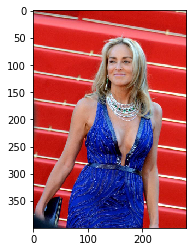

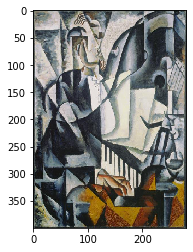

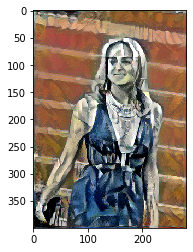

In [13]:
from matplotlib import pyplot as plt

# Przetwarzany obraz
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Styl referencyjny
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Wygenerowany obraz
plt.imshow(img)
plt.show()


Pamiętaj o tym, że technika ta przeprowadza transformację polegającą na zmianie tekstur lub ich przeniesieniu. Najlepiej sprawdza się z obrazami referencyjnymi wypełnionymi wyraźnymi teksturami i obrazami źródłowymi, które nie wymagają dużej ilości szczegółów do bycia rozpoznawalnymi. Zwykle nie da się w ten sposób wykonać operacji zmiany stylu portretu. Algorytm ten jest bliższy klasycznym technikom przetwarzania sygnału niż sztucznej inteligencji, a więc nie należy od niego oczekiwać cudów!

Działanie tego algorytmu jest dość powolne, ale transformacja ta jest na tyle prosta, że można jej dokonać również za pomocą małej, szybkiej jednokierunkowej sieci konwolucyjnej (wymogiem jest dysponowanie odpowiednim zbiorem danych treningowych). Szybki transfer stylu może być osiągnięty poprzez wygenerowanie wejściowych i wyjściowych obrazów treningowych utrzymanych w jednym stylu za pomocą techniki zaprezentowanej w tym podrozdziale. Po wykonaniu tej operacji należy wytrenować prostą sieć konwolucyjną pod kątem wykonywania transformacji zgodnej z określonym stylem. Teraz zmiana stylu obrazu będzie przeprowadzana praktycznie natychmiastowo w wyniku jednej iteracji algorytmu małej konwolucyjnej sieci neuronowej.

## Wnioski

* Transfer stylu polega na utworzeniu nowego obrazu, na którym zachowana zostanie treść przetwarzanego obrazu, ale zostanie ona przedstawiona w stylu obrazu referencyjnego.
* Treść może zostać rozpoznana przez aktywacje wysokopoziomowych warstw konwolucyjnej sieci neuronowej.
* Styl może zostać rozpoznany przez wewnętrzne korelacje aktywacji różnych warstw konwolucyjnej sieci neuronowej.
* Uczenie głębokie pozwala na utworzenie mechanizmu transferu stylu w formie procesu optymalizacji korzystającego z funkcji straty zdefiniowanej przy użyciu wytrenowanej wcześniej konwolucyjnej sieci neuronowej.
* Tę prostą ideę można rozbudowywać i modyfikować.
